## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.25, 0.5]
redice_lr_patient = [5, 10, 15]

In [8]:
from keras.callbacks import ReduceLROnPlateau
import itertools
results = {}

for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 13:16:31.612978 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 13:16:31.613974 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 13:16:31.616966 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 13:16:31.698782 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5


W0723 13:16:31.945090 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 13:16:31.955065 17608 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 13:16:32.064769 17608 deprecation.py:323] From C:\Users\vince\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 2s 44us/step - loss: 1.2413 - acc: 0.5672 - val_loss: 1.4757 - val_acc: 0.4745
Epoch 15/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2197 - acc: 0.5757 - val_loss: 1.4815 - val_acc: 0.4736
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1997 - acc: 0.5842 - val_loss: 1.4647 - val_acc: 0.4815
Epoch 17/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1809 - acc: 0.5887 - val_loss: 1.4584 - val_acc: 0.4799
Epoch 18/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1623 - acc: 0.5980 - val_loss: 1.4711 - val_acc: 0.4784
Epoch 19/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1434 - acc: 0.6049 - val_loss: 1.4683 - val_acc: 0.4818
Epoch 20/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1263 - acc: 0.6124 - val_loss: 1.4666 - val_acc: 0.4805
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.7761 - acc: 0.3836 - val_loss: 1.8385 - val_acc: 0.3638
Epoch 3/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.6423 - acc: 0.4238 - val_loss: 1.7379 - val_acc: 0.3982
Epoch 4/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.5640 - acc: 0.4523 - val_loss: 1.6494 - val_acc: 0.4234
Epoch 5/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.5065 - acc: 0.4704 - val_loss: 1.6047 - val_acc: 0.4425
Epoch 6/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.4588 - acc: 0.4885 - val_loss: 1.5826 - val_acc: 0.4526
Epoch 7/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.4211 - acc: 0.5013 - val_loss: 1.5411 - val_acc: 0.4568
Epoch 8/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.3891 - acc: 0.5121 - val_loss: 1.5375 - val_acc: 0.4601
Epoch 9/25
50000/50000 [=================

50000/50000 [==============================] - 2s 43us/step - loss: 1.0585 - acc: 0.6375 - val_loss: 1.4524 - val_acc: 0.4927
Numbers of exp: 5, reduce_factor: 0.25, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)  

Epoch 13/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2686 - acc: 0.5559 - val_loss: 1.4606 - val_acc: 0.4785
Epoch 14/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2500 - acc: 0.5628 - val_loss: 1.4571 - val_acc: 0.4788
Epoch 15/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.2281 - acc: 0.5719 - val_loss: 1.4580 - val_acc: 0.4810
Epoch 16/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.2076 - acc: 0.5790 - val_loss: 1.4607 - val_acc: 0.4791
Epoch 17/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.1879 - acc: 0.5863 - val_loss: 1.4394 - val_acc: 0.4876
Epoch 18/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.1683 - acc: 0.5943 - val_loss: 1.4392 - val_acc: 0.4873
Epoch 19/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.1500 - acc: 0.6019 - val_loss: 1.4298 - val_acc: 0.4949
Epoch 20/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.2120 - acc: 0.2662 - val_loss: 2.2956 - val_acc: 0.2908
Epoch 2/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.7646 - acc: 0.3822 - val_loss: 1.8715 - val_acc: 0.3452
Epoch 3/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.6379 - acc: 0.4229 - val_loss: 1.7089 - val_acc: 0.4007
Epoch 4/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.5637 - acc: 0.4486 - val_loss: 1.6809 - val_acc: 0.4154
Epoch 5/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.5082 - acc: 0.4689 - val_loss: 1.6015 - val_acc: 0.4366
Epoch 6/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.4632 - acc: 0.4838 - val_loss: 1.5748 - val_acc: 0.4451
Epoch 7/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.4258 - acc: 0.4967 - val_loss: 1.5402 - val_acc

50000/50000 [==============================] - 2s 43us/step - loss: 0.6429 - acc: 0.7961 - val_loss: 1.3347 - val_acc: 0.5516

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 24/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.6394 - acc: 0.7960 - val_loss: 1.3352 - val_acc: 0.5516
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.6399 - acc: 0.7966 - val_loss: 1.3358 - val_acc: 0.5520
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024 

50000/50000 [==============================] - 2s 44us/step - loss: 2.1660 - acc: 0.2757 - val_loss: 2.1896 - val_acc: 0.2748
Epoch 11/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.1469 - acc: 0.2795 - val_loss: 2.1723 - val_acc: 0.2805
Epoch 12/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.1287 - acc: 0.2852 - val_loss: 2.1576 - val_acc: 0.2828
Epoch 13/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.1122 - acc: 0.2891 - val_loss: 2.1428 - val_acc: 0.2854
Epoch 14/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.0957 - acc: 0.2934 - val_loss: 2.1303 - val_acc: 0.2888
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0834 - acc: 0.2969 - val_loss: 2.1180 - val_acc: 0.2922
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0712 - acc: 0.3018 - val_loss: 2.1066 - val_acc: 0.2958
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 92us/step - loss: 2.7587 - acc: 0.1443 - val_loss: 2.6006 - val_acc: 0.1877
Epoch 2/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.5095 - acc: 0.1924 - val_loss: 2.4611 - val_acc: 0.2161
Epoch 3/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.4032 - acc: 0.2152 - val_loss: 2.3810 - val_acc: 0.2290
Epoch 4/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.3359 - acc: 0.2304 - val_loss: 2.3235 - val_acc: 0.2425
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.2871 - acc: 0.2433 - val_loss: 2.2823 - val_acc: 0.2523
Epoch 6/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.2491 - acc: 0.2515 - val_loss: 2.2483 - val_acc: 0.2601
Epoch 7/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.2162 - acc: 0.2598 - val_loss: 2.2212 - val_acc

50000/50000 [==============================] - 2s 45us/step - loss: 1.9743 - acc: 0.3297 - val_loss: 2.0319 - val_acc: 0.3260
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.9660 - acc: 0.3323 - val_loss: 2.0242 - val_acc: 0.3271
Numbers of exp: 15, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.1238 - acc: 0.2821 - val_loss: 2.1826 - val_acc: 0.2761
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.1071 - acc: 0.2862 - val_loss: 2.1678 - val_acc: 0.2796
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0917 - acc: 0.2911 - val_loss: 2.1538 - val_acc: 0.2845
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0781 - acc: 0.2941 - val_loss: 2.1408 - val_acc: 0.2875
Epoch 16/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.0645 - acc: 0.2984 - val_loss: 2.1288 - val_acc: 0.2906
Epoch 17/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0531 - acc: 0.3013 - val_loss: 2.1176 - val_acc: 0.2953
Epoch 18/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.0408 - acc: 0.3051 - val_loss: 2.1072 - val_acc: 0.2978
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.8580 - acc: 0.3625 - val_loss: 2.6935 - val_acc: 0.2313
Epoch 2/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.5425 - acc: 0.4545 - val_loss: 5.4619 - val_acc: 0.1420
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4181 - acc: 0.4976 - val_loss: 1.8922 - val_acc: 0.3645
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3495 - acc: 0.5235 - val_loss: 2.1844 - val_acc: 0.2889
Epoch 5/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2865 - acc: 0.5462 - val_loss: 1.8847 - val_acc: 0.3632
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2250 - acc: 0.5665 - val_loss: 1.7497 - val_acc: 0.3938
Epoch 7/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1743 - acc: 0.5859 - val_loss: 1.8148 - val_ac

50000/50000 [==============================] - 2s 45us/step - loss: 1.5080 - acc: 0.4737 - val_loss: 1.6421 - val_acc: 0.4293
Epoch 24/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4972 - acc: 0.4788 - val_loss: 1.6298 - val_acc: 0.4339
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4859 - acc: 0.4825 - val_loss: 1.6272 - val_acc: 0.4341
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.7037 - acc: 0.4088 - val_loss: 1.7791 - val_acc: 0.3853
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6801 - acc: 0.4161 - val_loss: 1.7631 - val_acc: 0.3894
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6585 - acc: 0.4233 - val_loss: 1.7482 - val_acc: 0.3978
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6399 - acc: 0.4291 - val_loss: 1.7293 - val_acc: 0.4028
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6220 - acc: 0.4343 - val_loss: 1.7162 - val_acc: 0.4063
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6042 - acc: 0.4421 - val_loss: 1.7048 - val_acc: 0.4093
Epoch 17/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5892 - acc: 0.4468 - val_loss: 1.6967 - val_acc: 0.4115
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 118us/step - loss: 2.6699 - acc: 0.1675 - val_loss: 2.5195 - val_acc: 0.2214
Epoch 2/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.2976 - acc: 0.2433 - val_loss: 2.3325 - val_acc: 0.2615
Epoch 3/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.1350 - acc: 0.2855 - val_loss: 2.1784 - val_acc: 0.2901
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.0318 - acc: 0.3111 - val_loss: 2.0858 - val_acc: 0.3057
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.9566 - acc: 0.3311 - val_loss: 2.0138 - val_acc: 0.3225
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.8988 - acc: 0.3478 - val_loss: 1.9516 - val_acc: 0.3367
Epoch 7/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.8510 - acc: 0.3624 - val_loss: 1.9049 - val_ac

50000/50000 [==============================] - 2s 46us/step - loss: 1.5079 - acc: 0.4738 - val_loss: 1.6619 - val_acc: 0.4217
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4960 - acc: 0.4783 - val_loss: 1.6542 - val_acc: 0.4243
Numbers of exp: 25, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6726 - acc: 0.4174 - val_loss: 1.7496 - val_acc: 0.3944
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6519 - acc: 0.4236 - val_loss: 1.7391 - val_acc: 0.3982
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6336 - acc: 0.4292 - val_loss: 1.7207 - val_acc: 0.4072
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6145 - acc: 0.4357 - val_loss: 1.7043 - val_acc: 0.4092
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5978 - acc: 0.4418 - val_loss: 1.6947 - val_acc: 0.4101
Epoch 17/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5826 - acc: 0.4483 - val_loss: 1.6846 - val_acc: 0.4141
Epoch 18/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5680 - acc: 0.4529 - val_loss: 1.6759 - val_acc: 0.4165
Epoch 19/25
50000/50000 [=========

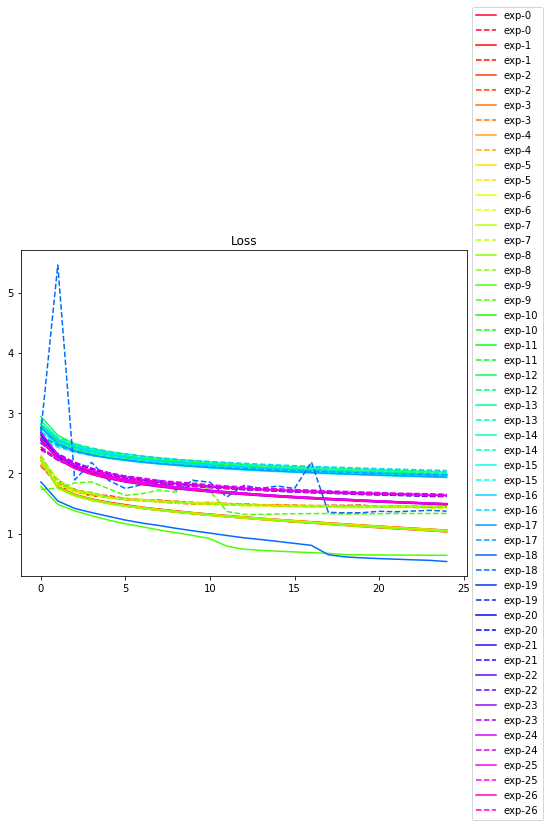

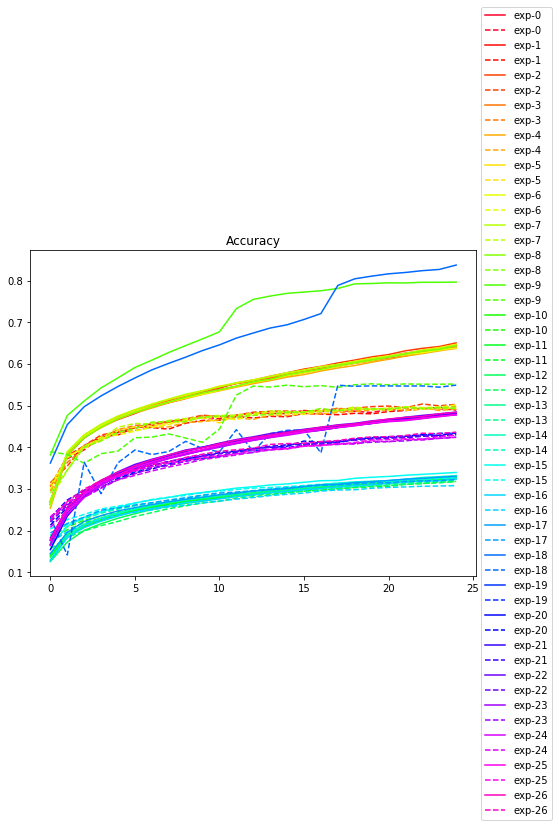

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()